## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 19: Optimizers, Notebook 4: Comparisons 2

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop, Adamax

from keras.utils import np_utils
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sbn; sbn.set()

Using TensorFlow backend.


In [2]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

-----
The cells below train a bunch of different optimizers. 

Note that due to the use of random numbers, every time you run this notebook you'll get different results. Usually they're close to one another, but sometimes an unusual run of numbers will give you unusual results - an important lesson for all training! So some of these figures are unlike those in the book, as I re-ran the notebook to prepare it for sharing. If you run everything again, you'll get a new crop of results.

Running these cells will build the models and train them. This may take a while! You can always stop things by hitting the black square (the "kernel stop button") in the toolbar at the top. Because the algorithms involve random numbers, your results will probably be different from those in this notebook, or in the book, but they should be roughly similar (I use a random seed so one run after the other on the same computer should be the same). The results here are only representative for this particular (relatively simple) dataset, and this particular (relatively simple) model. In general, most people start with Adam these days, and only use one of the other optimizers if Adam doesn't work well, or if there are particular reasons to favor another.

If you'd like to monitor the progress of training, in the calls to fit() below set verbose to 1 for a progress bar, or to 2 to have it print out one line per epoch.

-----

In [3]:
# Make the two-moons data

def make_data(num_samples=300, noise=0.2, random_state=42):
    (X, y) = make_moons(n_samples=num_samples, noise=noise, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    y_train = np_utils.to_categorical(y_train, number_of_classes)
    y_test = np_utils.to_categorical(y_test, number_of_classes)
    mms = MinMaxScaler()
    mms.fit(X)
    X_train = mms.transform(X_train)
    X_test = mms.transform(X_test)
    X = mms.transform(X)
    return (X, y, X_train, X_test, y_train, y_test)

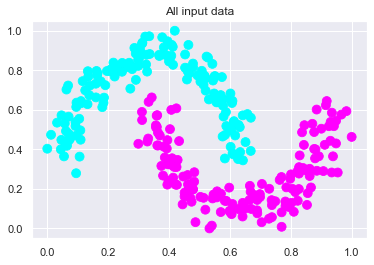

In [4]:
# Show the two-moons data

number_of_classes = 2
(X, y, X_train, X_test, y_train, y_test) = make_data(num_samples=300, noise=0.1, random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, s=80, lw=0.8, cmap='cool')
plt.title('All input data')
file_helper.save_figure('starting-error-data')
plt.show()

In [5]:

def plot_decision_boundary(filename, model):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    predictions = model.predict_classes(np.c_[xx.ravel(), yy.ravel()])
    #Z = np.asarray([np.argmax(z) for z in predictions])
    Z = predictions
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap='cool', alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=80, lw=1, cmap='cool')#plt.cm.Spectral)
    save_figure(filename)
    plt.show()

In [6]:
# The number of layers, and number of neurons per layer, were found by trial and error

def make_model():
    model = Sequential()
    model.add(Dense(12, input_dim=2, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(13, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(13, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))
    return model

In [7]:
# Make the data and save it

(X, y, X_train, X_test, y_train, y_test) = make_data(num_samples=300, noise=0.1, random_state=42)

In [8]:
# How many epochs should we train for? The larger this number, the slower everything will go.

num_epochs = 20000

In [9]:
# search for a good starting seed

def search_opt():
    for s in range(10):
        np.random.seed(s)
        model = make_model()
        model.compile(loss='categorical_crossentropy', metrics=['accuracy'], 
                  optimizer=SGD(lr=0.01))
        history = model.fit(X_train, y_train, epochs=2000, batch_size=32, verbose=0)
        final_loss = history.history['loss'][-1]
        if s==0:
            best_loss = final_loss
            best_s = s
        if final_loss < best_loss:
            best_loss = final_loss
            best_s = s
        print("run s=",s," final loss=",final_loss)
    print("Best seed = ",best_s," with best final loss=",best_loss)

In [10]:
# Runbatch gradient descent with a fixed learning rate

np.random.seed(2)
batchgd_model = make_model()
batchgd_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], 
              optimizer=SGD(lr=0.01))
history_batchgd = batchgd_model.fit(X_train, y_train, epochs=num_epochs, batch_size=len(X_train), verbose=0)

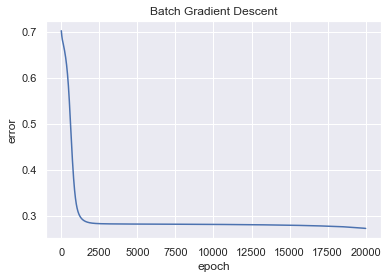

In [11]:
# Plot the error

plt.plot(history_batchgd.history['loss'])
plt.title('Batch Gradient Descent')
plt.xlabel('epoch')
plt.ylabel('error')
file_helper.save_figure('loss-graph-BatchGD')
plt.show()

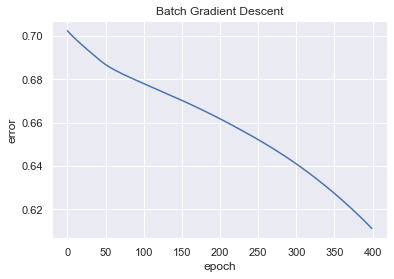

In [12]:
# Closeup of the first 400 epochs

plt.plot(history_batchgd.history['loss'][:400])
plt.title('Batch Gradient Descent')
plt.xlabel('epoch')
plt.ylabel('error')
file_helper.save_figure('loss-graph-BatchGD-first-400')
plt.show()

In [13]:
# Now try sotochastic gradient descent

np.random.seed(9)
sgd_model = make_model()
sgd_model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer=SGD(lr=0.01))
history_stochasticgd = sgd_model.fit(X_train, y_train, epochs=num_epochs, batch_size=1, verbose=0)

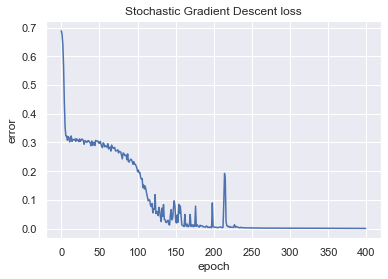

In [14]:
# Show the results

plt.plot(history_stochasticgd.history['loss'][:400])
plt.title('Stochastic Gradient Descent loss')
plt.xlabel('epoch')
plt.ylabel('error')
file_helper.save_figure('loss-graph-StochasticGD')
plt.show()

In [15]:
# Let's try minibatch SGD

np.random.seed(9)
mini_batchgd_model = make_model()
mini_batchgd_model.compile(loss='binary_crossentropy', metrics=['accuracy'], 
              optimizer=SGD(lr=0.01))
history_mini_batchgd = mini_batchgd_model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, verbose=0)

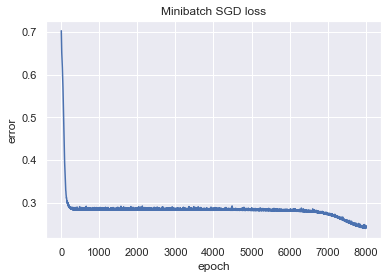

In [16]:
# Plot minibatch SGD loss

plt.plot(history_mini_batchgd.history['loss'][:8000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Minibatch SGD loss')
file_helper.save_figure('loss-graph-mini-batch-SGD')
plt.show()

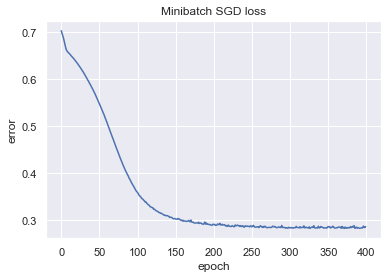

In [17]:
# Closeup of first 400 epochs

plt.plot(history_mini_batchgd.history['loss'][:400])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Minibatch SGD loss')
file_helper.save_figure('loss-graph-mini-batch-SGD-first-400')
plt.show()

In [18]:
# Try minibatch SGD with momentum

np.random.seed(9)
mini_batchgd_mom_model = make_model()
mini_batchgd_mom_model.compile(loss='binary_crossentropy', metrics=['accuracy'], 
              optimizer=SGD(lr=0.01, momentum=0.9))
history_mini_batchgd_mom = mini_batchgd_mom_model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, verbose=0)

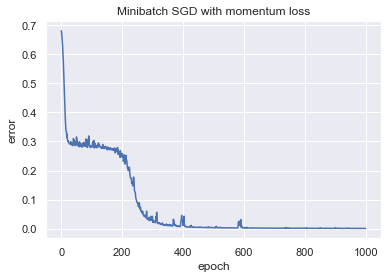

In [19]:
# Plot the loss

plt.plot(history_mini_batchgd_mom.history['loss'][:1000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Minibatch SGD with momentum loss')
file_helper.save_figure('loss-graph-mini-batch-mom-SGD')
plt.show()

In [20]:
# Try minibatch SGD with Nesterov momentum

np.random.seed(8)
mini_batchgd_nest_model = make_model()
mini_batchgd_nest_model.compile(loss='binary_crossentropy', metrics=['accuracy'], 
              optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True))
history_mini_batchgd_nest = mini_batchgd_nest_model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, verbose=0)

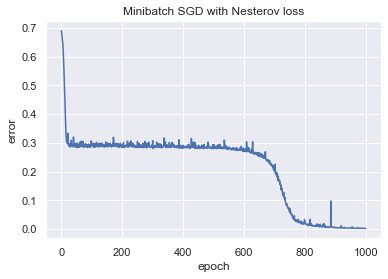

In [21]:
#Plot the loss

plt.plot(history_mini_batchgd_nest.history['loss'][:1000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Minibatch SGD with Nesterov loss')
file_helper.save_figure('loss-graph-mini-batch-nest-SGD')
plt.show()

In [22]:
# Try minibatch SGD with RMSprop 

np.random.seed(5)
rmsprop_model = make_model()
rmsprop_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=RMSprop(lr=0.01))
history_rmsprop = rmsprop_model.fit(X_train, y_train, epochs=num_epochs, batch_size=256, verbose=0)#num_epochs, batch_size=32, verbose=0)

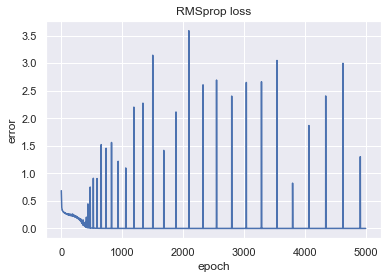

In [23]:
# Plot the error

plt.plot(history_rmsprop.history['loss'][:5000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('RMSprop loss')
file_helper.save_figure('loss-graph-rmsprop')
plt.show()

In [24]:
# Minibatch SGD with Adagrad

np.random.seed(6)
adagrad_model = make_model()
adagrad_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adagrad(lr=0.01))
history_adagrad = adagrad_model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, verbose=0)

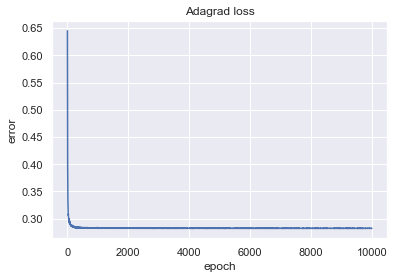

In [25]:
# Plot the error

plt.plot(history_adagrad.history['loss'][:10000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Adagrad loss')
file_helper.save_figure('loss-graph-adagrad')
plt.show()

In [26]:
# Minibatch SGD with Adadelta

np.random.seed(9)
adadelta_model = make_model()
adadelta_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adadelta(lr=1.0))
history_adadelta = adadelta_model.fit(X_train, y_train, epochs=num_epochs, batch_size=16, verbose=0)

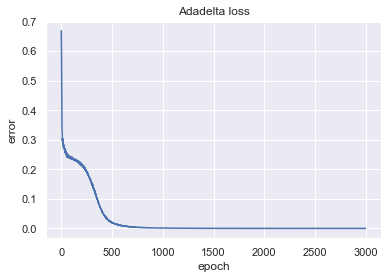

In [27]:
# Plot the loss

plt.plot(history_adadelta.history['loss'][:3000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Adadelta loss')
file_helper.save_figure('loss-graph-adadelta')
plt.show()

In [28]:
# Minibatch SGD with Adam

np.random.seed(2)
adam_model = make_model()
adam_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(lr=0.001))
history_adam = adam_model.fit(X_train, y_train, epochs=num_epochs, batch_size=64, verbose=0)

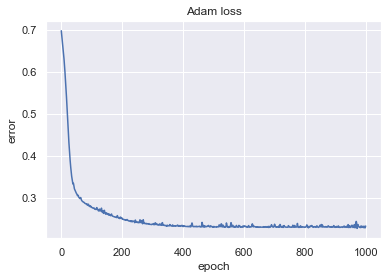

In [29]:
# Plot the loss

plt.plot(history_adam.history['loss'][:1000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Adam loss')
file_helper.save_figure('loss-graph-adam')
plt.show()

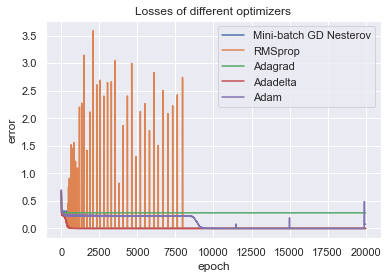

In [30]:
# Let's see all the losses in one place. 

plt.plot(history_mini_batchgd_nest.history['loss'], label='Mini-batch GD Nesterov')
plt.plot(history_rmsprop.history['loss'], label='RMSprop')
plt.plot(history_adagrad.history['loss'], label='Adagrad')
plt.plot(history_adadelta.history['loss'], label='Adadelta')
plt.plot(history_adam.history['loss'], label='Adam')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='upper right')
plt.title('Losses of different optimizers')
file_helper.save_figure('loss-graphs-set')
plt.show()

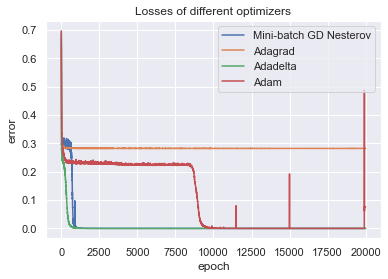

In [31]:
# Let's look at just a few of the optimizers. 

plt.plot(history_mini_batchgd_nest.history['loss'], label='Mini-batch GD Nesterov')
#plt.plot(history_rmsprop.history['loss'], label='RMSprop')
plt.plot(history_adagrad.history['loss'], label='Adagrad')
plt.plot(history_adadelta.history['loss'], label='Adadelta')
plt.plot(history_adam.history['loss'], label='Adam')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='upper right')
plt.title('Losses of different optimizers')
file_helper.save_figure('loss-graphs-set-without-rms')
plt.show()

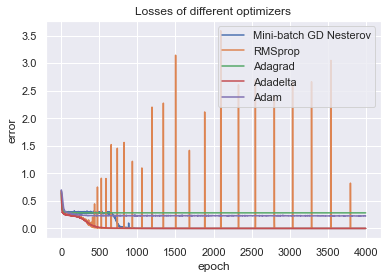

In [32]:
# Another look but just at the start of training

plot_limit = 4000
plt.plot(history_mini_batchgd_nest.history['loss'][:plot_limit], label='Mini-batch GD Nesterov')
plt.plot(history_rmsprop.history['loss'][:plot_limit], label='RMSprop')
plt.plot(history_adagrad.history['loss'][:plot_limit], label='Adagrad')
plt.plot(history_adadelta.history['loss'][:plot_limit], label='Adadelta')
plt.plot(history_adam.history['loss'][:plot_limit], label='Adam')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='upper right')
plt.title('Losses of different optimizers')
file_helper.save_figure('loss-graphs-set-start')
plt.show()

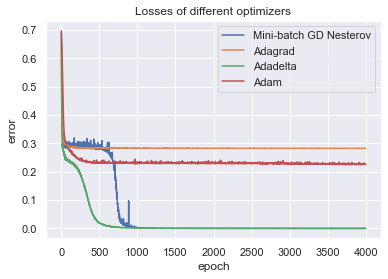

In [33]:
# Another look, again just at the start of training

plt.plot(history_mini_batchgd_nest.history['loss'][:plot_limit], label='Mini-batch GD Nesterov')
#plt.plot(history_rmsprop.history['loss'][:plot_limit], label='RMSprop')
plt.plot(history_adagrad.history['loss'][:plot_limit], label='Adagrad')
plt.plot(history_adadelta.history['loss'][:plot_limit], label='Adadelta')
plt.plot(history_adam.history['loss'][:plot_limit], label='Adam')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='upper right')
plt.title('Losses of different optimizers')
file_helper.save_figure('loss-graphs-set-start-without-rms')
plt.show()